## Import Data and Libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import itertools

from scipy.spatial import Voronoi, voronoi_plot_2d, KDTree, Delaunay
from scipy.stats import boxcox

from shapely.geometry import Polygon

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer

In [89]:
colonies = pd.read_excel('./data/Orig ID - reduced EBS.xlsx', sheet_name='Raw data')

In [90]:
weather = pd.read_csv('./data/math_242_datashare/weather.csv')

## Data Preparation

### Clean and Merge Weather Data

In [91]:
weather = weather[['datetime', 'temp', 'humidity']]

In [92]:
weather['datetime'] = pd.to_datetime(weather['datetime'], format='%Y-%m-%d')

<ipython-input-92-4a9d14070ebb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['datetime'] = pd.to_datetime(weather['datetime'], format='%Y-%m-%d')


In [93]:
weather = weather.groupby(weather.datetime.dt.year).mean()

In [94]:
weather = weather.fillna(weather.mean())

In [95]:
weather = weather.reset_index()

In [96]:
colonies = colonies[colonies['YEAR'] >= 1984]

In [97]:
colonies = pd.merge(colonies, weather, left_on='YEAR', right_on='datetime', how='left')

### Remove Duplicated Data

In [98]:
# NOTE: THERE ARE DUPLICATED IDS
duplicates = colonies[colonies.duplicated(subset=['ORIG_ID', 'AGE'], keep=False)]
duplicates

,ORIG_ID,lifespan,YEAR,AGE,LAT,LON,DEAD,YEARS_REMAINING,BORN,DIEFUTURE,SURVIVED,datetime,temp,humidity
366,140426,11,1985,5,31.893632,-109.003484,0,6,0,0,1,1985,16.774432,48.169886
367,140426,11,1986,6,31.893632,-109.003484,0,5,0,0,1,1986,16.669697,47.642727
1095,181766,14,1997,12,31.893974,-109.000731,0,2,0,0,1,1997,18.390750,38.997648
1096,181766,14,1998,13,31.893974,-109.000731,0,1,0,1,0,1998,19.512275,44.053293
1097,181766,14,1986,1,31.894021,-109.000657,0,13,1,0,1,1986,16.669697,47.642727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10737,132587,5,2020,5,31.894706,-109.004283,0,0,0,0,1,2020,20.442350,33.593169
10738,132587,5,2019,4,31.894706,-109.004283,0,1,0,0,1,2019,19.299726,39.179452
10739,132587,5,2018,3,31.894706,-109.004283,0,2,0,0,1,2018,19.896438,35.582740
10740,132587,5,2016,1,31.894706,-109.004283,0,4,1,0,1,2016,18.125410,39.839617


In [99]:
# HOWEVER, THERE ARE NO DUPLICATES WITH SAME LIFESPAN
colonies[colonies.duplicated(subset=['ORIG_ID', 'lifespan', 'AGE'], keep=False)]

,ORIG_ID,lifespan,YEAR,AGE,LAT,LON,DEAD,YEARS_REMAINING,BORN,DIEFUTURE,SURVIVED,datetime,temp,humidity


In [100]:
for id in duplicates['ORIG_ID'].unique():
  lifespans = colonies.loc[colonies['ORIG_ID'] == id, 'lifespan'].unique()
  for j in range(len(lifespans)):
    colonies.loc[(colonies['ORIG_ID'] == id) & (colonies['lifespan'] == lifespans[j]), 'ORIG_ID'] = id*10 + j

In [101]:
colonies[colonies.duplicated(subset=['ORIG_ID', 'AGE'], keep=False)]

,ORIG_ID,lifespan,YEAR,AGE,LAT,LON,DEAD,YEARS_REMAINING,BORN,DIEFUTURE,SURVIVED,datetime,temp,humidity


In [102]:
cids = []
iids = []

for id in colonies['ORIG_ID'].unique():
  temp = colonies.loc[colonies['ORIG_ID'] == id, 'lifespan']
  if temp.shape[0] == temp.iloc[0] - 1:
    cids.append(id)
  else:
    iids.append(id)

In [103]:
len(cids)

682

In [104]:
len(iids)

466

### Set Training/Test Split

In [105]:
years = colonies['YEAR'].unique()

In [106]:
years_train = years[:int(0.9 * len(years))]
years_test = years[int(0.9 * len(years)):]

As previously discussed, we should train to split these sets environmentally (I think this will impart a large change on the data). This can be done by simply taking the average humidity/rainfall in the area (Rodeo, NM) at the end of August per year). Particularly becuase the training set below is going to be heavily drought years. 

In [107]:
years_train

array([1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [108]:
years_test

array([2017, 2018, 2019, 2020])

In [109]:
TRAIN_SIZE = colonies[colonies['YEAR'].isin(years_train) & (colonies['BORN']==1)].shape[0]

## Compute Basic Features

In [110]:
for y in years:
    temp = colonies[colonies['YEAR'] == y]
    n_colonies = temp.shape[0]
    kd = KDTree(temp[['LAT', 'LON']].values)

    MD = []
    NA = []

    for i in range(n_colonies):
        nn = kd.query(temp[['LAT', 'LON']].values[i,:], k=2)[1]
        nn = nn[1:]
        dists = kd.query(temp[['LAT', 'LON']].values[i,:], k=2)[0]
        dists = dists[1:]
        MD.append(min(dists))
        NA.append(sum(temp.iloc[nn]['AGE'].values))

    colonies.loc[temp.index.values,'MIN_DIST'] = MD
    colonies.loc[temp.index.values,'NEIGHBOR_AGE'] = NA

## Early Analysis

### Survivorship

In [ ]:
ages = colonies.loc[colonies['ORIG_ID'].isin(cids), 'lifespan']
max_age = max(ages)
min_age = min(ages)
cum_survival = []
survival = []
remaining = len(ages)

for i in range(min_age, max_age+1):
  survival.append((remaining - len(ages[ages >= i]))/remaining)
  cum_survival.append(len(ages[ages >= i]) / len(ages))
  remaining = len(ages[ages >= i])

Text(0, 0.5, '% Decrease in Living Colonies')

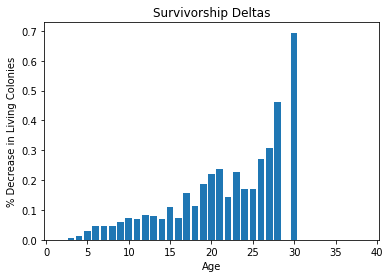

In [ ]:
# survivorship deltas
plt.bar(list(range(min_age, max_age+1)), survival)
plt.title('Survivorship Deltas')
plt.xlabel('Age')
plt.ylabel('% Decrease in Living Colonies')

Text(0, 0.5, '% of Colonies Alive')

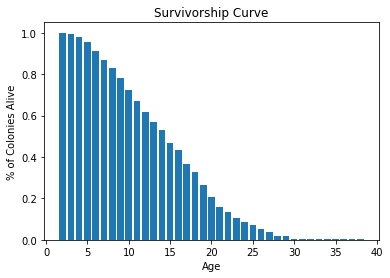

In [ ]:
# survivorship curve
plt.bar(list(range(min_age, max_age+1)), cum_survival)
plt.title('Survivorship Curve')
plt.xlabel('Age')
plt.ylabel('% of Colonies Alive')

### Distance

(array([7.120e+02, 4.382e+03, 4.322e+03, 1.260e+03, 3.610e+02, 6.900e+01,
        3.900e+01, 2.200e+01, 2.000e+00, 1.300e+01]),
 array([6.24599872e-06, 5.06007127e-05, 9.49554267e-05, 1.39310141e-04,
        1.83664855e-04, 2.28019569e-04, 2.72374283e-04, 3.16728997e-04,
        3.61083711e-04, 4.05438425e-04, 4.49793139e-04]),
 <a list of 10 Patch objects>)

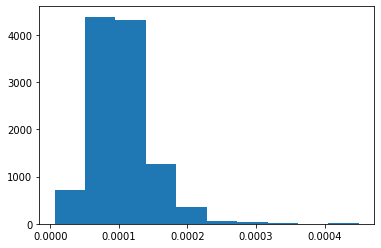

In [ ]:
plt.hist(colonies['MIN_DIST'])

(array([2.000e+00, 1.200e+01, 2.000e+01, 1.500e+02, 6.260e+02, 2.358e+03,
        5.187e+03, 2.429e+03, 3.470e+02, 5.100e+01]),
 array([-11.9835695 , -11.55588483, -11.12820016, -10.70051548,
        -10.27283081,  -9.84514614,  -9.41746147,  -8.98977679,
         -8.56209212,  -8.13440745,  -7.70672277]),
 <a list of 10 Patch objects>)

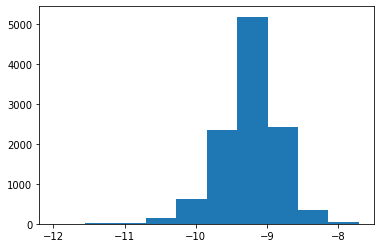

In [ ]:
colonies['LOG_MIN_DIST'] = np.log(colonies['MIN_DIST'])
plt.hist(colonies['LOG_MIN_DIST'])

Text(0, 0.5, 'Log Min Distance to Nearest Neighbor')

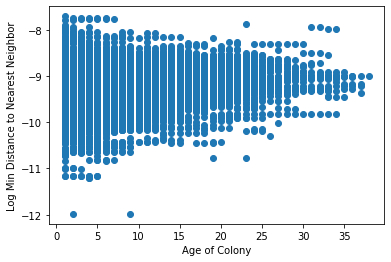

In [ ]:
plt.scatter(colonies['AGE'], colonies['LOG_MIN_DIST'])
plt.xlabel('Age of Colony')
plt.ylabel('Log Min Distance to Nearest Neighbor')

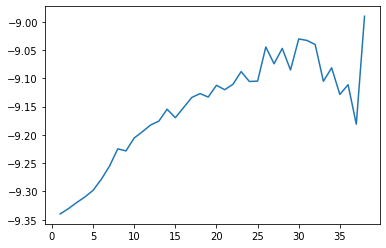

In [ ]:
plt.plot(colonies.groupby('AGE')['LOG_MIN_DIST'].mean())

[Text(0, 0.5, 'log Distance'),
 Text(0.5, 0, 'Indication of Death in Following Year'),
 Text(0.5, 1.0, 'Survivorship Prediction by Distance')]

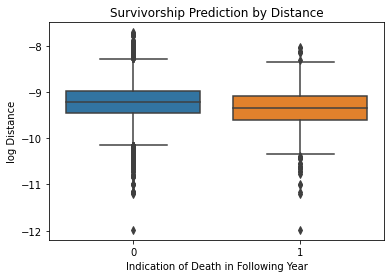

In [ ]:
sns.boxplot(x = colonies['DIEFUTURE'],
            y = colonies['LOG_MIN_DIST']).set(xlabel='Indication of Death in Following Year', ylabel='log Distance', title='Survivorship Prediction by Distance')

### Age 

(array([4229., 2928., 1401., 1192.,  578.,  463.,  252.,   65.,   51.,
          23.]),
 array([ 1. ,  4.6,  8.2, 11.8, 15.4, 19. , 22.6, 26.2, 29.8, 33.4, 37. ]),
 <a list of 10 Patch objects>)

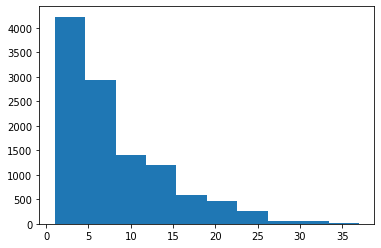

In [ ]:
plt.hist(colonies['NEIGHBOR_AGE'])

Text(0.5, 1.0, 'Age of Colony vs Age of Nearest Neighbor')

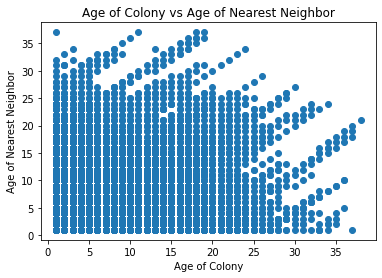

In [ ]:
plt.scatter(colonies['AGE'], colonies['NEIGHBOR_AGE'])
plt.xlabel('Age of Colony')
plt.ylabel('Age of Nearest Neighbor')
plt.title('Age of Colony vs Age of Nearest Neighbor')

[Text(0, 0.5, 'Neighbor Age'),
 Text(0.5, 0, 'Indication of Death in Following Year'),
 Text(0.5, 1.0, 'Survivorship Predicition by Neighbor Age')]

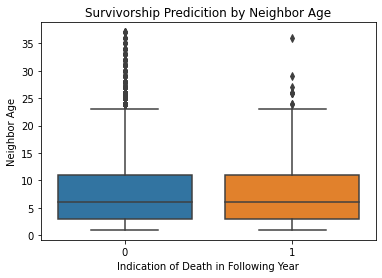

In [ ]:
sns.boxplot(x = colonies['DIEFUTURE'],
            y = colonies['NEIGHBOR_AGE']).set(xlabel='Indication of Death in Following Year', ylabel='Neighbor Age', title='Survivorship Predicition by Neighbor Age')

### Weather

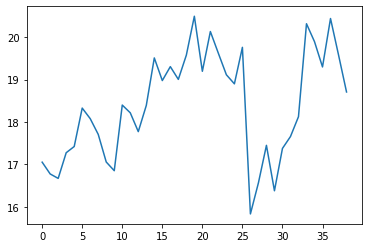

In [ ]:
plt.plot(weather['temp'])

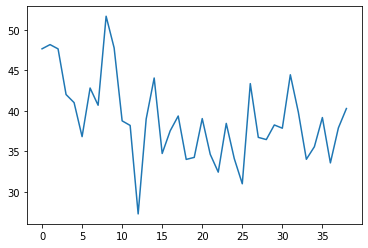

In [ ]:
plt.plot(weather['humidity'])

[Text(0, 0.5, 'Temperature'),
 Text(0.5, 0, 'Indication of Death in Following Year'),
 Text(0.5, 1.0, 'Survivorship Predicition by Temperature')]

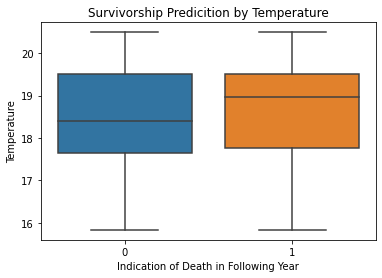

In [ ]:
sns.boxplot(x = colonies['DIEFUTURE'],
            y = colonies['temp']).set(xlabel='Indication of Death in Following Year', ylabel='Temperature', title='Survivorship Predicition by Temperature')

[Text(0, 0.5, 'Humidity'),
 Text(0.5, 0, 'Indication of Death in Following Year'),
 Text(0.5, 1.0, 'Survivorship Predicition by Humidity')]

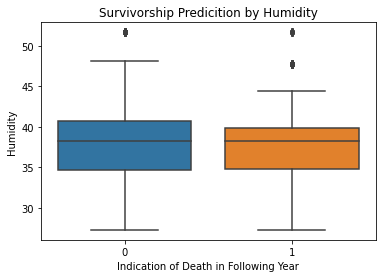

In [ ]:
sns.boxplot(x = colonies['DIEFUTURE'],
            y = colonies['humidity']).set(xlabel='Indication of Death in Following Year', ylabel='Humidity', title='Survivorship Predicition by Humidity')

## Model Definition

In [116]:
# Use balanced weighting of classes because far more colonies live than die
lm = LogisticRegression(class_weight='balanced')

In [117]:
# Use leave one out cross validation 
cv = KFold(n_splits=TRAIN_SIZE, shuffle=False)

## Baseline Models

In [118]:
factors = ['MIN_DIST', 'NEIGHBOR_AGE', 'temp', 'humidity']
subsets = []
results1 = []

In [119]:
for L in range(1, len(factors) + 1):
    for subset in itertools.combinations(factors, L):
        subsets.append(list(subset))

In [120]:
for subset in tqdm(subsets):
  X_train = colonies.loc[colonies['YEAR'].isin(years_train) & (colonies['BORN'] == 1), subset].values
  y_train = colonies.loc[colonies['YEAR'].isin(years_train) & (colonies['BORN'] == 1), 'DIEFUTURE'].values

  hits = cross_val_score(lm, X_train, y_train, scoring='accuracy', cv=cv)
  die_acc = (hits * y_train).sum() / y_train.sum()
  live_acc = (hits * (1-y_train)).sum() / (1-y_train).sum()

  results1.append((die_acc + live_acc)/2)

  0%|          | 0/15 [00:00<?, ?it/s]

In [121]:
results1 = np.array(results1)
subsets = np.array(subsets)

<ipython-input-121-73349413a12d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subsets = np.array(subsets)


In [122]:
np.max(results1)

0.5621846579040396

In [123]:
subsets[np.argwhere(results1 == np.max(results1))]

array([[list(['NEIGHBOR_AGE', 'temp'])],
       [list(['MIN_DIST', 'NEIGHBOR_AGE', 'temp'])]], dtype=object)

In [124]:
np.min(results1)

0.49845743484269045

In [125]:
subsets[np.argwhere(results1 == np.min(results1))]

array([[list(['NEIGHBOR_AGE', 'temp', 'humidity'])],
       [list(['MIN_DIST', 'NEIGHBOR_AGE', 'temp', 'humidity'])]],
      dtype=object)

In [127]:
pd.DataFrame({'Variables': subsets, 'CV': results1})

,Variables,CV
0,[MIN_DIST],0.500000
1,[NEIGHBOR_AGE],0.556030
2,[temp],0.520134
3,[humidity],0.525597
4,"[MIN_DIST, NEIGHBOR_AGE]",0.556030
5,"[MIN_DIST, temp]",0.520134
6,"[MIN_DIST, humidity]",0.525597
7,"[NEIGHBOR_AGE, temp]",0.562185
8,"[NEIGHBOR_AGE, humidity]",0.534515
9,"[temp, humidity]",0.520134


## How Many Neighbors Actually Matter?

### K Nearest Neighbors - Uniform Interaction

In [128]:
MAX_K = 10
ks = np.arange(1, MAX_K + 1)
results2 = np.zeros(len(ks))

In [129]:
for k in tqdm(ks):
    
    cnnu = colonies.copy()
    cnnu['NEIGHBORS_MEAN_AGE'] = None
    
    for y in years:
        temp = cnnu[cnnu['YEAR'] == y]
        n_colonies = temp.shape[0]
        kd = KDTree(temp[['LAT', 'LON']].values)

        mean_age = []
        for i in range(n_colonies):

            nn = kd.query(temp[['LAT', 'LON']].values[i,:], k=k+1)[1]
            nn = nn[1:]
            mean_age.append(temp.iloc[nn]['AGE'].mean())

        cnnu.loc[temp.index.values,'NEIGHBORS_MEAN_AGE'] = mean_age
        
    cnnu = cnnu.loc[cnnu['BORN']==1, ['ORIG_ID', 'YEAR', 'DIEFUTURE', 'NEIGHBORS_MEAN_AGE', 'temp']]
    
    X_train = cnnu.loc[cnnu['YEAR'].isin(years_train), ['NEIGHBORS_MEAN_AGE', 'temp']].values
    y_train = cnnu.loc[cnnu['YEAR'].isin(years_train), 'DIEFUTURE'].values

    hits = cross_val_score(lm, X_train, y_train, scoring='accuracy', cv=cv)
    die_acc = (hits * y_train).sum() / y_train.sum()
    live_acc = (hits * (1-y_train)).sum() / (1-y_train).sum()
    results2[k-1] = (die_acc + live_acc)/2

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Unweighted Leave-One-Out Balanced Accuracy vs K')

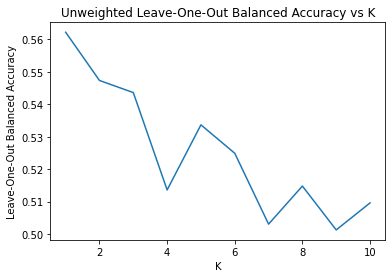

In [130]:
plt.plot(ks, results2)
plt.xlabel("K")
plt.ylabel("Leave-One-Out Balanced Accuracy")
plt.title("Unweighted Leave-One-Out Balanced Accuracy vs K")

In [131]:
max(results2)

0.5621846579040396

### K Nearest Neighbors - Weighted Interaction

In [132]:
results3 = np.zeros(len(ks))

In [133]:
for k in tqdm(ks):
    
    cnnu = colonies.copy()
    cnnu['NEIGHBORS_MEAN_AGE'] = None
    
    for y in years:
        temp = cnnu[cnnu['YEAR'] == y]
        n_colonies = temp.shape[0]
        kd = KDTree(temp[['LAT', 'LON']].values)

        mean_age = []
        for i in range(n_colonies):
            nn = kd.query(temp[['LAT', 'LON']].values[i,:], k=k+1)[1]
            nn = nn[1:]
            dists = kd.query(temp[['LAT', 'LON']].values[i,:], k=k+1)[0]
            dists = dists[1:]
            weights = (1/dists) / sum(1/dists)
            mean_age.append(sum(temp.iloc[nn]['AGE'].values * weights))

        cnnu.loc[temp.index.values,'NEIGHBORS_MEAN_AGE'] = mean_age
        
    cnnu = cnnu.loc[cnnu['BORN']==1, ['ORIG_ID', 'YEAR', 'DIEFUTURE', 'NEIGHBORS_MEAN_AGE', 'temp']]
    
    X_train = cnnu.loc[cnnu['YEAR'].isin(years_train), ['NEIGHBORS_MEAN_AGE', 'temp']].values
    y_train = cnnu.loc[cnnu['YEAR'].isin(years_train), 'DIEFUTURE'].values

    hits = cross_val_score(lm, X_train, y_train, scoring='accuracy', cv=cv)
    die_acc = (hits * y_train).sum() / y_train.sum()
    live_acc = (hits * (1-y_train)).sum() / (1-y_train).sum()
    results3[k-1] = (die_acc + live_acc)/2

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Weighted Leave-One-Out Balanced Accuracy vs K')

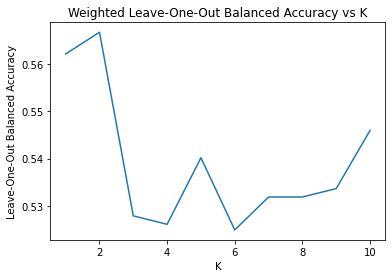

In [134]:
plt.plot(ks, results3)
plt.xlabel("K")
plt.ylabel("Leave-One-Out Balanced Accuracy")
plt.title("Weighted Leave-One-Out Balanced Accuracy vs K")

In [ ]:
max(results3)

## An Alternative Definition of Neighborhoods: Voronoi Neighbors

### Voronoi Neighbors - Helper Function

In [ ]:
# based on https://gist.github.com/Sklavit/e05f0b61cb12ac781c93442fbea4fb55
def voronoi_finite_polygons_2d(vor):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    all_points = np.concatenate((vor.points, vor.vertices), axis=0)
    x_min, y_min = tuple(all_points.min(0))
    x_max, y_max = tuple(all_points.max(0))
    
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_ridges = []

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                new_ridges.append((p2, v1, v2))
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            slope = -t[0] / t[1]
            anchor = vor.vertices[v2]

            bottom = np.array(((y_min - anchor[1] + slope * anchor[0]) / slope, y_min))
            top = np.array(((y_max - anchor[1] + slope * anchor[0]) / slope, y_max))
            left = np.array((x_min, slope * (x_min - anchor[0]) + anchor[1]))
            right = np.array((x_min, slope * (x_min - anchor[0]) + anchor[1]))
            wall_intercepts = np.stack((bottom, top, left, right), axis=0)
            
            far_point = wall_intercepts[np.argmin(np.linalg.norm(anchor-wall_intercepts, axis=1))]

            new_ridges.append((p2, v2, len(new_vertices)))
            new_vertices.append(far_point.tolist())

        all_ridges.update({p1: new_ridges})

    return np.asarray(new_vertices), all_ridges

### Voronoi Neighbors - Example

In [ ]:
 years[5]

In [ ]:
y = years[5]
temp = colonies[colonies['YEAR'] == y].copy()
points = temp[['LAT', 'LON']].values
vor = Voronoi(points)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=1, line_alpha=0.6, point_size=3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Voronoi Neighbors - Uniform Interaction





In [ ]:
cnnu = colonies.copy()
cnnu['NEIGHBORS_MEAN_AGE'] = None
cnnu['N_NEIGHBORS'] = None

for y in years:
    temp = cnnu[cnnu['YEAR'] == y]
    n_colonies = temp.shape[0]
    vor = Voronoi(temp[['LAT', 'LON']].values)
    _, all_ridges = voronoi_finite_polygons_2d(vor)

    mean_age = []
    nn = []

    for i in range(n_colonies):
      ridges = all_ridges[i]
      neighbors = []
      for (p2, v1, v2) in ridges:
        neighbors.append(p2)

      mean_age.append(temp.iloc[neighbors]['AGE'].mean())
      nn.append(len(neighbors))

    cnnu.loc[temp.index.values,'NEIGHBORS_MEAN_AGE'] = mean_age
    cnnu.loc[temp.index.values,'N_NEIGHBORS'] = nn

print('Mean num neighbors: ' + str(cnnu['N_NEIGHBORS'].mean()))

cnnu = cnnu.loc[cnnu['BORN']==1, ['ORIG_ID', 'YEAR', 'DIEFUTURE', 'NEIGHBORS_MEAN_AGE', 'temp']]

X_train = cnnu.loc[cnnu['YEAR'].isin(years_train), ['NEIGHBORS_MEAN_AGE', 'temp']].values
y_train = cnnu.loc[cnnu['YEAR'].isin(years_train), 'DIEFUTURE'].values

hits = cross_val_score(lm, X_train, y_train, scoring='accuracy', cv=cv)
die_acc = (hits * y_train).sum() / y_train.sum()
live_acc = (hits * (1-y_train)).sum() / (1-y_train).sum()
print('Leave-One-Out Balanced Accuracy: ' + str((die_acc + live_acc)/2))


### Voronoi Neighbors - Length-Weighted Interaction

In [ ]:
cnnu = colonies.copy()
cnnu['NEIGHBORS_MEAN_AGE'] = None

for y in years:
    temp = cnnu[cnnu['YEAR'] == y]
    n_colonies = temp.shape[0]
    vor = Voronoi(temp[['LAT', 'LON']].values)

    vertices, all_ridges = voronoi_finite_polygons_2d(vor)
    mean_age = []

    for i in range(n_colonies):
      ridges = all_ridges[i]
      neighbors = []
      weights = []
      for (p2, v1, v2) in ridges:
        neighbors.append(p2)
        weights.append(np.linalg.norm(vertices[v1]-vertices[v2]))
      weights = weights / sum(weights)
      mean_age.append(sum(temp.iloc[neighbors]['AGE'].values * weights))

    cnnu.loc[temp.index.values,'NEIGHBORS_MEAN_AGE'] = mean_age

cnnu = cnnu.loc[cnnu['BORN']==1, ['ORIG_ID', 'YEAR', 'DIEFUTURE', 'NEIGHBORS_MEAN_AGE', 'temp']]

X_train = cnnu.loc[cnnu['YEAR'].isin(years_train), ['NEIGHBORS_MEAN_AGE', 'temp']].values
y_train = cnnu.loc[cnnu['YEAR'].isin(years_train), 'DIEFUTURE'].values

hits = cross_val_score(lm, X_train, y_train, scoring='accuracy', cv=cv)
die_acc = (hits * y_train).sum() / y_train.sum()
live_acc = (hits * (1-y_train)).sum() / (1-y_train).sum()
print('Leave-One-Out Balanced Accuracy: ' + str((die_acc + live_acc)/2))

### Ridge Ranking vs Nearest Neighbor

In [ ]:
cnnu = colonies.copy()

for y in years:

    temp = cnnu[cnnu['YEAR'] == y]
    n_colonies = temp.shape[0]

    vor = Voronoi(temp[['LAT', 'LON']].values)
    kd = KDTree(temp[['LAT', 'LON']].values)

    vertices, all_ridges = voronoi_finite_polygons_2d(vor)

    ranks = []
    top = []

    for i in range(n_colonies):

      ridges = all_ridges[i]
      neighbors = []
      weights = []

      for (p2, v1, v2) in ridges:
        neighbors.append(p2)
        weights.append(np.linalg.norm(vertices[v1]-vertices[v2]))

      weights = -1 * np.array(weights)
      
      dists = np.linalg.norm(vor.points[[i]] - vor.points[neighbors], axis=1)

      order = weights.argsort()
      rank = order.argsort()

      ranks.append(rank[dists.argmin()] / len(rank))
      top.append(1 if rank[dists.argmin()] == 0 else 0)

In [ ]:
# mean rank percentile
1-np.array(ranks).mean()

In [ ]:
# percentage of time where top ridge is nearest neighbor
sum(top) / len(top)

## Estimating Aggression

In [ ]:
for y in years:
  temp = colonies[colonies['YEAR'] == y]
  n_colonies = temp.shape[0]
  kd = KDTree(temp[['LAT', 'LON']].values)

  nns = []

  for i in range(n_colonies):

      nn = kd.query(temp[['LAT', 'LON']].values[i,:], k=2)[1]
      nns.append(nn[1])

  nns = np.array(nns)

  targets = []
  kills = []

  for i in range(n_colonies):

    t = np.argwhere(nns == i)
    targets.append(t.shape[0])
    kills.append(temp['DIEFUTURE'].values[t].sum())

  colonies.loc[temp.index.values,'TARGETS'] = targets
  colonies.loc[temp.index.values,'KILLS'] = kills

In [ ]:
colonies[['TARGETS', 'KILLS']] = colonies.groupby('ORIG_ID')[['TARGETS', 'KILLS']].cumsum()

In [ ]:
colonies['AGGRESSION'] = colonies['KILLS'] / colonies['TARGETS']

In [ ]:
for y in years:
  temp = colonies[colonies['YEAR'] == y]
  n_colonies = temp.shape[0]
  kd = KDTree(temp[['LAT', 'LON']].values)

  nkills = []

  for i in range(n_colonies):

      nn = kd.query(temp[['LAT', 'LON']].values[i,:], k=2)[1]
      nkills.append(temp['KILLS'].values[nn[1]])

  colonies.loc[temp.index.values,'NEIGHBOR_KILLS'] = nkills

In [ ]:
max(colonies['NEIGHBOR_KILLS'])

7.0

In [ ]:
X_train = colonies.loc[colonies['YEAR'].isin(years_train) & (colonies['BORN'] == 1), ['NEIGHBOR_AGE', 'NEIGHBOR_KILLS', 'temp']].values
y_train = colonies.loc[colonies['YEAR'].isin(years_train) & (colonies['BORN'] == 1), 'DIEFUTURE'].values

hits = cross_val_score(lm, X_train, y_train, scoring='accuracy', cv=cv)
die_acc = (hits * y_train).sum() / y_train.sum()
live_acc = (hits * (1-y_train)).sum() / (1-y_train).sum()

(die_acc + live_acc)/2

0.723366648455828

## Validation on Test Set

In [ ]:
fitted = lm.fit(X_train, y_train)

In [ ]:
X_test = colonies.loc[colonies['YEAR'].isin(years_test) & (colonies['BORN'] == 1), ['NEIGHBOR_AGE', 'NEIGHBOR_KILLS', 'temp']].values
y_test = colonies.loc[colonies['YEAR'].isin(years_test) & (colonies['BORN'] == 1), 'DIEFUTURE'].values

In [ ]:
y_pred = fitted.predict(X_test)

In [ ]:
y_pred

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1])

In [ ]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [ ]:
balanced_accuracy_score(y_test, y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.8695652173913043